*This Note book referenced [WuJiaocan's Github](https://github.com/WuJiaocan/tensorflow), [XueYouluo's Github](https://github.com/xueyouluo/my_seq2seq/blob/90c86bacd5cb88ad8d381de28fe3bdf8421a0036/notebooks/MyS2S.ipynb)

*Major contribution of this notebook is: provided a flexible NMT network building (change of layers, cell-type, switch between bi-direction and uni-direction RNN, switch between attention mechanisms) based on Tensorflow through parameter setting

In [0]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [0]:
import tensorflow as tf
import codecs
import sys
import numpy as np
import time

# INSTRUCTION -0: RECORD PARAMETERS

!! Please record all hyper parameters [HERE](https://docs.google.com/spreadsheets/d/1VgRGGDv_ynvTORz3vHtH2VgRQnyxv9qBkDkPjSpDj3c/edit?usp=sharing) **BEFORE** start traning. 

This is to avoid duplicated/similar experiments among our team

# INSTRUCTION-1: SET TRAINING DATASET

Set NUM_EXAMPLES AND Run All Cells

Time for 1 Epoch on Colab GPU for reference:

1. 100,000 sentence pairs: 285s
2.  50,000 sentence pairs: 127s

### 1.Create Vocabulary

In [0]:
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("")

In [0]:
NUM_SENT = 50000

In [0]:
src_path = 'en_clean.txt'
tgt_path = 'fr_clean.txt'

In [0]:
def read_train_data(txt_path, num_examples):
  text = []
  with open(txt_path, 'r', encoding="utf-8") as f:
    for line in f.readlines():
      line = line[7:-6]
      text.append(line.strip('\n'))
    return text[:num_examples]

In [0]:
src = read_train_data(src_path, NUM_SENT)
tgt = read_train_data(tgt_path, NUM_SENT)

In [0]:
def read_test_data(txt_path, num_examples = 400):
  text = []
  with open(txt_path, 'r', encoding="utf-8") as f:
    for line in f.readlines():
      line = line[7:-6]
      text.append(line.strip('\n'))
    return text[-num_examples:]

In [0]:
src_test = read_test_data(src_path)
tgt_test = read_test_data(tgt_path)

In [0]:
print('size of number of source sentences from dataset for training: {}'.format(len(src)))
print('size of number of target sentences from dataset for training: {}'.format(len(tgt)))

size of number of source sentences from dataset for training: 50000
size of number of target sentences from dataset for training: 50000


In [0]:
print('size of number of source sentences from dataset for testing: {}'.format(len(src_test)))
print('size of number of target sentences from dataset for testing: {}'.format(len(tgt_test)))

size of number of source sentences from dataset for testing: 400
size of number of target sentences from dataset for testing: 400


In [0]:
# Display examples for quick check

for i in range(5):
  print(src[i])

 global health where do physiotherapy and rehabilitation research fit ? 
 carabin 
 comment on the misappropriation of bibliographical references in science . the example of anti aging medicine 
 anti aging medicine , a science based , essential medicine 
 underwater dive in fresh water complicated by a cardiorespiratory arrest on obstructive shock 


In [0]:
for i in range(5):
  print(tgt[i])

 la place des cheveux et des poils dans les rituels et le sacre 
 les carabins 
 du detournement des references bibliographiques en science . l exemple de la medecine anti age 
 la medecine anti age , une medecine scientifique , indispensable 
 plongee subaquatique en eau douce compliquee d un arret cardiorespiratoire sur choc obstructif 


In [0]:
import codecs
import collections
from operator import itemgetter

def create_vocab(RAW_DATA, VOCAB_OUTPUT):
    counter = collections.Counter()

    for line in RAW_DATA:
        for word in line.strip().lower().split():
            counter[word] += 1

    sorted_word_to_cnt = sorted(counter.items(), key=itemgetter(1), reverse=True)
    sorted_words = [x[0] for x in sorted_word_to_cnt]

    sorted_words =  ['<pad>'] + ['<sos>'] + ['<eos>'] + ['<unk>'] + sorted_words 

    with codecs.open(VOCAB_OUTPUT, "w", encoding="utf-8") as file_output:
        for word in sorted_words:
            file_output.write(word + "\n")
    return sorted_words

In [0]:
vocab_src = create_vocab(src, 'vocab.en')
vocab_tgt = create_vocab(tgt, 'vocab.fr')

In [0]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)

print('size of source vocab {}'.format(vocab_size_src))
print('size of target vocab {}'.format(vocab_size_tgt))

size of source vocab 28711
size of target vocab 35019


In [0]:
print(vocab_src[-5:])

['homolateral', 'peritonsillar', 'radt', 'lobbying', 'mediacalcosis']


In [0]:
print(vocab_tgt[-5:])

['respective', 'periamygdalien', 'bachelot', 'lobbying', 'mediacalcose']


### 2.Convert Text to Numbers

In [0]:
import codecs
import sys

def text_to_int(RAW_DATA, VOCAB, OUTPUT_DATA):

  with codecs.open(VOCAB, "r", encoding="utf-8") as f_vocab:
      vocab = [w.strip() for w in f_vocab.readlines()]
      word_to_id = {k:v for (k,v) in zip(vocab, range(len(vocab)))}

  def get_id(word):
      return word_to_id[word] if word in word_to_id else word_to_id["<unk>"]

  fout = codecs.open(OUTPUT_DATA, "w", encoding="utf-8")
  for line in RAW_DATA:
      words = line.strip().split() + ["<eos>"]

      out_line = " ".join([str(get_id(w)) for w in words]) + "\n"
      fout.write(out_line)
  fout.close()

In [0]:
text_to_int(src, 'vocab.en', 'train.en')
text_to_int(tgt, 'vocab.fr', 'train.fr')

### 4. Create Training Dataset

In [0]:
def MakeDataset(file_path):
    dataset = tf.data.TextLineDataset(file_path)
    # split by space
    dataset = dataset.map(lambda string: tf.string_split([string]).values)
    # convert string to number
    dataset = dataset.map(
        lambda string: tf.string_to_number(string, tf.int32))
    # calc # word/sentence and put in dataset with sentence
    dataset = dataset.map(lambda x: (x, tf.size(x)))
    return dataset

def MakeSrcTrgDataset(src_path, trg_path, batch_size):

    src_data = MakeDataset(src_path)
    trg_data = MakeDataset(trg_path)
    #   ds[0][0]source sentence
    #   ds[0][1]len of source sentence
    #   ds[1][0]target sentence
    #   ds[1][1]len of target sentence
    dataset = tf.data.Dataset.zip((src_data, trg_data))

    # delete empty and super-long sentence
    def FilterLength(src_tuple, trg_tuple):
        ((src_input, src_len), (trg_label, trg_len)) = (src_tuple, trg_tuple)
        src_len_ok = tf.logical_and(
            tf.greater(src_len, 1), tf.less_equal(src_len, MAX_LEN))
        trg_len_ok = tf.logical_and(
            tf.greater(trg_len, 1), tf.less_equal(trg_len, MAX_LEN))
        return tf.logical_and(src_len_ok, trg_len_ok)
    dataset = dataset.filter(FilterLength)
    
    #   1.trg_input: "<sos> X Y Z"
    #   2.trg_label: "X Y Z <eos>"
    #   file: "X Y Z <eos>", need to produce "<sos> X Y Z" and add to dataset
    def MakeTrgInput(src_tuple, trg_tuple):
        ((src_input, src_len), (trg_label, trg_len)) = (src_tuple, trg_tuple)
        trg_input = tf.concat([[SOS_ID], trg_label[:-1]], axis=0)
        return ((src_input, src_len), (trg_input, trg_label, trg_len))
    
    dataset = dataset.map(MakeTrgInput)

    dataset = dataset.shuffle(10000)

    # define shape after padding
    padded_shapes = (
        (tf.TensorShape([None]),
         tf.TensorShape([])), 
        (tf.TensorShape([None]),
         tf.TensorShape([None]),
         tf.TensorShape([]))) 
    
    # padded_batch to pad
    batched_dataset = dataset.padded_batch(batch_size, padded_shapes)
    return batched_dataset

### 3.Define NMT

In [0]:
def single_rnn_cell(cell_name, hid_size, keep_prob):
    if cell_name == "GRU":
        cell = tf.contrib.rnn.GRUCell(hid_size)
    elif cell_name == "LSTM":
        cell = tf.contrib.rnn.LSTMCell(hid_size)
    elif cell_name == "BASIC":
        cell = tf.contrib.rnn.BasicRNNCell(hid_size)
        
    if keep_prob < 1.0:
      cell = tf.contrib.rnn.DropoutWrapper(
            cell=cell,
            input_keep_prob=keep_prob,
            output_keep_prob=keep_prob)
    
    return cell


def multi_rnn_cell(cell_name, hid_size, num_layers, keep_prob):
    cells = []
    for _ in range(num_layers):
        cell = single_rnn_cell(cell_name, hid_size, keep_prob)
        cells.append(cell)
    
    if len(cells) > 1:
        final_cell = tf.contrib.rnn.MultiRNNCell(cells=cells)
    else:
        final_cell = cells[0]
    return final_cell
  
  
def single_biRNN_pair(cell_name, hid_size, keep_prob):
    if cell_name == "bi-GRU":
      enc_cell_fw = single_rnn_cell('GRU', hid_size, keep_prob)
      enc_cell_bw = single_rnn_cell('GRU', hid_size, keep_prob)
    elif cell_name == "bi-LSTM":
      enc_cell_fw = single_rnn_cell('LSTM', hid_size, keep_prob)
      enc_cell_bw = single_rnn_cell('LSTM', hid_size, keep_prob)
    return enc_cell_fw, enc_cell_bw
    
def multi_biRNN_pair(cell_name, hid_size, num_layers, keep_prob):
    stacked_biRNN_fw = []
    stacked_biRNN_bw = []
    for _ in range(num_layers):
        enc_cell_fw, enc_cell_bw = single_biRNN_pair(cell_name, hid_size, keep_prob)
        stacked_biRNN_fw.append(enc_cell_fw)
        stacked_biRNN_bw.append(enc_cell_bw)
    
    if len(stacked_biRNN_fw) > 1:
        final_stacked_biRNN_fw = tf.contrib.rnn.MultiRNNCell(cells=stacked_biRNN_fw)
        final_stacked_biRNN_bw = tf.contrib.rnn.MultiRNNCell(cells=stacked_biRNN_bw)
    else:
        final_stacked_biRNN_fw = stacked_biRNN_fw[0]
        final_stacked_biRNN_bw = stacked_biRNN_bw[0]
    return final_stacked_biRNN_fw, final_stacked_biRNN_bw

In [0]:
class NMTModel(object):
  """
  defind the nmt model
  
  """
  # define variables needed by nmt
  def __init__(self, 
               dec_layer, 
               enc_layer,
               dec_cell_name, 
               enc_cell_name,
               optimizer, 
               lr,
               hid_size, 
               attention,
               drop_out):
    
    self.dec_cell_name = dec_cell_name
    self.enc_cell_name = enc_cell_name
    self.dec_layer = dec_layer
    self.enc_layer = enc_layer
    self.attention = attention
    
    self.hid_size = hid_size
    self.opt = optimizer
    self.lr = lr
    
    self.keep_prob = 1.0 - drop_out

    # EMBEDDING SETUP
    
    self.src_embedding = tf.get_variable(
          "src_emb", [SRC_VOCAB_SIZE, self.hid_size])
    self.trg_embedding = tf.get_variable(
          "trg_emb", [TRG_VOCAB_SIZE, self.hid_size])

      # define variables for softmax layer
    if SHARE_EMB_AND_SOFTMAX:
         self.softmax_weight = tf.transpose(self.trg_embedding)
    else:
         self.softmax_weight = tf.get_variable(
             "weight", [self.hid_size, TRG_VOCAB_SIZE])
    self.softmax_bias = tf.get_variable(
          "softmax_bias", [TRG_VOCAB_SIZE])
     
  # calculate forward graph
  # src_input, src_size, trg_input, trg_label, trg_size are from MakeSrcTrgDataset
  
  def forward(self, src_input, src_size, trg_input, trg_label, trg_size):
      batch_size = tf.shape(src_input)[0]
      
      # *************************
      # **** EMBEDDING SCOPE ****
      # *************************
      
      with tf.variable_scope("Embeddings"):

        # convert word_int input to embeddings
        src_emb = tf.nn.embedding_lookup(self.src_embedding, src_input)
        trg_emb = tf.nn.embedding_lookup(self.trg_embedding, trg_input)

        # set drop_out rate
        src_emb = tf.nn.dropout(src_emb, self.keep_prob)
        trg_emb = tf.nn.dropout(trg_emb, self.keep_prob)

      # *************************
      # ***** ENCODER SCOPE *****
      # *************************

      with tf.variable_scope("encoder"):
        
        if not 'bi' in self.enc_cell_name:
        
          enc_cell = multi_rnn_cell(self.enc_cell_name, 
                                    self.hid_size, 
                                    self.enc_layer, 
                                    self.keep_prob)
          enc_outputs, enc_state = tf.nn.dynamic_rnn(enc_cell, 
                                                     inputs=src_emb, 
                                                     sequence_length=src_size, 
                                                     dtype=tf.float32) 
        
        else:
          
          stacked_biRNN_fw, stacked_biRNN_bw = multi_biRNN_pair(self.enc_cell_name, 
                                                                self.hid_size, 
                                                                self.enc_layer, 
                                                                self.keep_prob)
          enc_outputs, enc_state = tf.nn.bidirectional_dynamic_rnn(cell_fw = stacked_biRNN_fw,
                                                                   cell_bw = stacked_biRNN_bw,
                                                                   inputs = src_emb,
                                                                   sequence_length = src_size,
                                                                   dtype = tf.float32)
          
          # concatenate two outputs of LSTM cell as 1 tensor
          # enc_outputs = (output_fw, output_bw)
          enc_outputs = tf.concat([enc_outputs[0], enc_outputs[1]], -1)
          
    
      # *************************
      # ***** DECODER SCOPE *****
      # *************************
      
      with tf.variable_scope("decoder"):
        
        dec_cell = multi_rnn_cell(self.dec_cell_name, self.hid_size, self.dec_layer, self.keep_prob)
    
    
        # OPTIONS FOR ATTENTION MECHANISM
        if self.attention == 'Bahdanau':
        
          attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                  self.hid_size, 
                  enc_outputs,
                  memory_sequence_length = src_size)
          
        if self.attention == 'Luong':

          attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                  self.hid_size,
                  enc_outputs,
                  memory_sequence_length=src_size)

        # ATTENTION WRAPPER: 
        # wrap dec_cell and attention mechanisim
        attention_cell = tf.contrib.seq2seq.AttentionWrapper(
                dec_cell, 
                attention_mechanism,
                attention_layer_size=self.hid_size)

        # use attention_cell and dynamic_rnn construct decoder
        # here relay totally on attention as the information source
        dec_outputs, _ = tf.nn.dynamic_rnn(
                attention_cell, trg_emb, trg_size, dtype=tf.float32)

        
      # ************************
      # ***** OPTIMIZATION *****
      # ************************
      
      # LOSS/LOG PERPLEXITY
      output = tf.reshape(dec_outputs, [-1, HIDDEN_SIZE])
      logits = tf.matmul(output, self.softmax_weight) + self.softmax_bias
      loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=tf.reshape(trg_label, [-1]), logits=logits)

      # set padding weight as 0 when calc average loss
      label_weights = tf.sequence_mask(
          trg_size, maxlen=tf.shape(trg_label)[1], dtype=tf.float32)
      label_weights = tf.reshape(label_weights, [-1])
      cost = tf.reduce_sum(loss * label_weights)
      cost_per_token = cost / tf.reduce_sum(label_weights)

      # define backprop
      trainable_variables = tf.trainable_variables()

      # OPTIONS FOR OPTIMIZER
      # define optimization method/steps
      grads = tf.gradients(cost / tf.to_float(batch_size),
                           trainable_variables)
      
      grads, _ = tf.clip_by_global_norm(grads, clip_norm = 5)

      if self.opt == 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate = self.lr)
      
      elif self.opt == 'sgd':        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = self.lr)
        
      elif self.opt == 'rmsprop':     
        optimizer = tf.train.RMSPropOptimizer(learning_rate = self.lr)
      
      train_op = optimizer.apply_gradients(zip(grads, trainable_variables))
      
      return cost_per_token, train_op

### 4.Training

In [0]:
def run_epoch(session, cost_op, train_op, saver, step):
    while True:
        try:
            # execute train_op and calc loss
            cost, _ = session.run([cost_op, train_op])
            if step % 10 == 0:
                print("After %d steps, per token cost is %.3f" % (step, cost))
            # save checkpoint per 200 steps
            if step % 200 == 0:
                saver.save(session, CHECKPOINT_PATH, global_step=step)
            step += 1
        except tf.errors.OutOfRangeError:
            break
    return step

#INSTRUCTION-2: SET TRAINING HYPER PARAMETERS

1. Normally just leave following things as they are, unless changed training dataset or dataset size:
  * SRC_TRAIN_DATA,
  * TRG_TRAIN_DATA,
  * SRC_VOCAB_SIZE
  * TRG_VOCAB_SIZE

2. Need to change CHECKPOINT_PATH each time for a training to distinguish different training setting (for easier recording)

3. Following Prameters can be tuned for research and experiment purpose:

  * HIDDEN_SIZE (# INTEGER)
  * DECODER_LAYERS (# INTEGER)
  * DECODER_CELL_TYPE (OPTIONS: 'LSTM', 'GRU', 'BASIC')
  * ENCODER_LAYERS (# INTEGER)
  * ENCODER_CELL_TYPE (OPTIONS: 'LSTM', 'GRU', 'BASIC', 'bi-LSTM', 'bi-GRU')
  * ATTENTION ('Luong', 'Bahdanau')
  * DROP_OUT (0~1.0)
  * OPTIMIZER (OPTIONS: 'adam', 'sgd', 'rmsprop')
  * LEARNING_RATE (0.0001 ~ 0.1)
  * NUM_EPOCH (#INTEGER: dont' use big number as it consumes time, could keep consistent across all experiments to compare whose loss decreased the most in certain epochs)
  * BATCH_SIZE (#INTEGER: 32, 64, 128, 256...)
  
  
  **NOTICE: ALL PARAM NAMES ARE CASE SENSITIVE**

In [0]:
CHECKPOINT_PATH = "./ckpt-exp09/google-brain-uni-rmsprop"  

HIDDEN_SIZE = 512
DECODER_LAYERS = 4                    # Num_layer for decoder LSTM
DECODER_CELL_TYPE = 'LSTM'
ENCODER_LAYERS = 4
ENCODER_CELL_TYPE = 'LSTM'
ATTENTION = 'Bahdanau'
OPTIMIZER = 'rmsprop'
DROPOUT = 0.2
LEARNING_RATE = 0.001

BATCH_SIZE = 128
NUM_EPOCH = 20


SRC_TRAIN_DATA = "train.en"
TRG_TRAIN_DATA = "train.fr"
SRC_VOCAB_SIZE = vocab_size_src       
TRG_VOCAB_SIZE = vocab_size_tgt 
SHARE_EMB_AND_SOFTMAX = True           # share weights between softmax layer and embedding layer
MAX_LEN = 100   # max length of a sentence
SOS_ID  = 1    # <sos> ID in target vocab

import time
def main():
  
    initializer = tf.random_uniform_initializer(-0.05, 0.05)
    
    tf.reset_default_graph()

    with tf.variable_scope("nmt_model", reuse=None, 
                           initializer=initializer):
        train_model = NMTModel(
                dec_layer = DECODER_LAYERS, 
                enc_layer = ENCODER_LAYERS,
                dec_cell_name =  DECODER_CELL_TYPE,
                enc_cell_name = ENCODER_CELL_TYPE,
                optimizer = OPTIMIZER, 
                lr = LEARNING_RATE,
                hid_size = HIDDEN_SIZE, 
                attention = ATTENTION,
                drop_out = DROPOUT)
  
    # define input data
    data = MakeSrcTrgDataset(SRC_TRAIN_DATA, TRG_TRAIN_DATA, BATCH_SIZE)
    iterator = data.make_initializable_iterator()
    (src, src_size), (trg_input, trg_label, trg_size) = iterator.get_next()
 
    # define forward graph
    cost_op, train_op = train_model.forward(src, src_size, trg_input,
                                            trg_label, trg_size)

    # train
    saver = tf.train.Saver()
    tf.add_to_collection('train_op', train_op)
    tf.add_to_collection('cost_op', cost_op)
    step = 0
    with tf.Session() as sess:
        writer = tf.summary.FileWriter('logs', sess.graph)
        writer.close()
        
        tf.global_variables_initializer().run()
        for i in range(NUM_EPOCH):
            time_start=time.time()
            print("-------In iteration: %d" % (i + 1))
            sess.run(iterator.initializer)
            step = run_epoch(sess, cost_op, train_op, saver, step)
            time_end=time.time()
            print('-------time cost',time_end-time_start,'s')
            print('                                        ')
            
if __name__ == "__main__":
    main()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
-------In iteration: 1
After 0 steps, per token cost is 10.460
After 10 steps, per token cost is 10.456
After 20 steps, 

### 5. Produce Model Structure

In [0]:
import tensorflow.contrib.slim as slim

def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

model_summary()

---------
Variables: name (type shape) [size]
---------
nmt_model/src_emb:0 (float32_ref 28711x128) [3675008, bytes: 14700032]
nmt_model/trg_emb:0 (float32_ref 35019x128) [4482432, bytes: 17929728]
nmt_model/softmax_bias:0 (float32_ref 35019) [35019, bytes: 140076]
encoder/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel:0 (float32 256x512) [131072, bytes: 524288]
encoder/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias:0 (float32 512) [512, bytes: 2048]
encoder/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel:0 (float32 256x512) [131072, bytes: 524288]
encoder/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/bias:0 (float32 512) [512, bytes: 2048]
encoder/bidirectional_rnn/fw/multi_rnn_cell/cell_2/lstm_cell/kernel:0 (float32 256x512) [131072, bytes: 524288]
encoder/bidirectional_rnn/fw/multi_rnn_cell/cell_2/lstm_cell/bias:0 (float32 512) [512, bytes: 2048]
encoder/bidirectional_rnn/fw/multi_rnn_cell/cell_3/lstm_cell/kernel:0 (float32 256x512) [131072

# INSTRUCTION 3 - INFERENCE USING TRAINED MODEL AND WEIGHT

### 6.Define Model Structure, Hyper Parameter Used in Training, Inference Function

1. Need to change LAST_CKPT_PATH every time you train and set it to the latest checkpoint, which is presented by the biggest number in CHECKPOINT_PATH

2. Keep other parameters as they are in the traning session, no need to change here

In [0]:
# read checkpoint path, number indicates the latest step
LAST_CKPT_PATH = "ckpt-exp09/google-brain-uni-rmsprop-7800"

# file for vocab
SRC_VOCAB = "vocab.en"
TRG_VOCAB = "vocab.fr"
SRC_VOCAB_SIZE = vocab_size_src       
TRG_VOCAB_SIZE = vocab_size_tgt 

# ID for <sos> and <eos> in vocab
SOS_ID = 1
EOS_ID = 2

SHARE_EMB_AND_SOFTMAX = True

In [0]:
class NMTModel(object):
  """
  defind the nmt model
  
  """
  # define variables needed by nmt
  def __init__(self, 
               dec_layer = DECODER_LAYERS, 
               enc_layer = ENCODER_LAYERS,
               dec_cell_name = DECODER_CELL_TYPE, 
               enc_cell_name = ENCODER_CELL_TYPE,
               optimizer = OPTIMIZER, 
               lr = LEARNING_RATE,
               hid_size = HIDDEN_SIZE, 
               attention = ATTENTION,
               drop_out = DROPOUT):
    
    self.dec_cell_name = dec_cell_name
    self.enc_cell_name = enc_cell_name
    self.dec_layer = dec_layer
    self.enc_layer = enc_layer
    self.attention = attention
    
    self.hid_size = hid_size
    self.opt = optimizer
    self.lr = lr
    
    self.keep_prob = 1.0 - drop_out

    # EMBEDDING SETUP
    
    self.src_embedding = tf.get_variable(
          "src_emb", [SRC_VOCAB_SIZE, self.hid_size])
    self.trg_embedding = tf.get_variable(
          "trg_emb", [TRG_VOCAB_SIZE, self.hid_size])

      # define variables for softmax layer
    if SHARE_EMB_AND_SOFTMAX:
         self.softmax_weight = tf.transpose(self.trg_embedding)
    else:
         self.softmax_weight = tf.get_variable(
             "weight", [self.hid_size, TRG_VOCAB_SIZE])
    self.softmax_bias = tf.get_variable(
          "softmax_bias", [TRG_VOCAB_SIZE])
  
  def inference(self, src_input):
      # As dynamic rnn requires batch input, 
      # to infer one single sentence, we set batch = 1
      src_size = tf.convert_to_tensor([len(src_input)], dtype=tf.int32)
      src_input = tf.convert_to_tensor([src_input], dtype=tf.int32)
      src_emb = tf.nn.embedding_lookup(self.src_embedding, src_input)
      
     
      # *************************
      # ***** ENCODER SCOPE *****
      # *************************

      with tf.variable_scope("encoder"):
        
        if not 'bi' in self.enc_cell_name:
        
          enc_cell = multi_rnn_cell(self.enc_cell_name, 
                                    self.hid_size, 
                                    self.enc_layer, 
                                    self.keep_prob)
          enc_outputs, enc_state = tf.nn.dynamic_rnn(enc_cell, 
                                                     inputs=src_emb, 
                                                     sequence_length=src_size, 
                                                     dtype=tf.float32) 
        
        else:
          
          stacked_biRNN_fw, stacked_biRNN_bw = multi_biRNN_pair(self.enc_cell_name, 
                                                                self.hid_size, 
                                                                self.enc_layer, 
                                                                self.keep_prob)
          enc_outputs, enc_state = tf.nn.bidirectional_dynamic_rnn(cell_fw = stacked_biRNN_fw,
                                                                   cell_bw = stacked_biRNN_bw,
                                                                   inputs = src_emb,
                                                                   sequence_length = src_size,
                                                                   dtype = tf.float32)
          
          # concatenate two outputs of LSTM cell as 1 tensor
          # enc_outputs = (output_fw, output_bw)
          enc_outputs = tf.concat([enc_outputs[0], enc_outputs[1]], -1)
          
    
      # *************************
      # ***** DECODER SCOPE *****
      # *************************
      
      with tf.variable_scope("decoder"):
        
        dec_cell = multi_rnn_cell(self.dec_cell_name, self.hid_size, self.dec_layer, self.keep_prob)
    
    
        # OPTIONS FOR ATTENTION MECHANISM
        if self.attention == 'Bahdanau':
        
          attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                  self.hid_size, 
                  enc_outputs,
                  memory_sequence_length = src_size)
          
        if self.attention == 'Luong':

          attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                  self.hid_size,
                  enc_outputs,
                  memory_sequence_length=src_size
                  )

        # ATTENTION WRAPPER: 
        # wrap dec_cell and attention mechanisim
        attention_cell = tf.contrib.seq2seq.AttentionWrapper(
                dec_cell, 
                attention_mechanism,
                attention_layer_size=self.hid_size,
                alignment_history=True)

      # Set the max step for decoder
      MAX_DEC_LEN=100

      with tf.variable_scope("decoder/rnn/attention_wrapper"):
        # use TensorArray store produced sentence
        init_array = tf.TensorArray(dtype=tf.int32, size=0,
            dynamic_size=True, clear_after_read=False)
        # start input for decoder with <sos> tag
        init_array = init_array.write(0, SOS_ID)
        # initilize attention cell
        init_loop_var = (
            attention_cell.zero_state(batch_size=1, dtype=tf.float32),
            init_array, 0)

        # condition for tf.while_loop：
        # loop until decoder outputs <eos> or hit max length setting
#         def continue_loop_condition(state, trg_ids, step):
#             return tf.reduce_all(tf.logical_and(
#                 tf.not_equal(trg_ids.read(step), EOS_ID),
#                 tf.less(step, MAX_DEC_LEN-1),
#                 tf.not_equal(trg_ids.read(step), trg_ids.read(step-1))))
          
        def continue_loop_condition(state, trg_ids, step):
            return tf.reduce_all(tf.logical_and(
                tf.not_equal(trg_ids.read(step), EOS_ID),
                tf.less(step, MAX_DEC_LEN-1)))

        def loop_body(state, trg_ids, step):
          
            # read last step output as input for attention cell
            trg_input = [trg_ids.read(step)]
            trg_emb = tf.nn.embedding_lookup(self.trg_embedding,
                                             trg_input)
            # FORWARD calc ATTENTION CELL and output decoder outputs/state
            dec_outputs, next_state = attention_cell.call(
                state=state, inputs=trg_emb)
            
            # calc logit for each candidate target vocab
            # select the max as output
            output = tf.reshape(dec_outputs, [-1, HIDDEN_SIZE])
            logits = (tf.matmul(output, self.softmax_weight)
                      + self.softmax_bias)
            next_id = tf.argmax(logits, axis=1, output_type=tf.int32)
            # write output word into trg_ids
            trg_ids = trg_ids.write(step+1, next_id[0])
            return next_state, trg_ids, step+1

        # execute tf.while_loop return trg_ides
        state, trg_ids, step = tf.while_loop(
            continue_loop_condition, loop_body, init_loop_var)
        
        return trg_ids.stack(), state

### 7. Test and Evaluate

In [0]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

def levenshtein(seq1, seq2):  
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )

    return matrix[size_x - 1, size_y - 1]

def translate_en_fr(src_sent, trgt_sent, plot_att = False, verbose = False):
    
    tf.reset_default_graph()
        
    # define the trained model
    with tf.variable_scope("nmt_model", reuse=None):
        model = NMTModel()
       
    # convert sentence to word_index according to vocab
    with codecs.open(SRC_VOCAB, "r", "utf-8") as f_vocab:
        src_vocab = [w.strip() for w in f_vocab.readlines()]
        src_id_dict = dict((src_vocab[x], x) for x in range(len(src_vocab)))
    test_en_ids = [(src_id_dict[token] if token in src_id_dict else src_id_dict['<unk>'])
                   for token in src_sent.split()]
    print('target sentence id: {}'.format(test_en_ids))

    # build inference based on saved model weights
    output_op, state_op = model.inference(test_en_ids)
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, LAST_CKPT_PATH)

    # read translation output
    output_ids = sess.run(output_op)
    print('target sentence id: {}'.format(output_ids))
    
    # convert translation idx into word
    with codecs.open(TRG_VOCAB, "r", "utf-8") as f_vocab:
        trg_vocab = [w.strip() for w in f_vocab.readlines()]
    output_text = ' '.join([trg_vocab[x] for x in output_ids])
    
    # output translation
    final_output_text = output_text.encode('utf8').decode(sys.stdout.encoding).strip('<eos>')
    
    bleu = sentence_bleu(trgt_sent.split(), final_output_text.split())
    lst = levenshtein(trgt_sent,final_output_text)
    
    if verbose:
      print("Source Sentence: " + src_sent)
      print("Real Translation: " + trgt_sent)
      print("Predicted Translation: " + final_output_text)
      print("Levenshetein Distance: " + str(lst))
      print("***BLEU Score***: "+ str(bleu))
    
    
    # PLOT ATTENTION PLOT OPTION
    
    def plot_attention(attention, src_sent, pred_sent):

      fig = plt.figure(figsize=(10,10))
      ax = fig.add_subplot(1, 1, 1)
      ax.matshow(attention, cmap='viridis')

      fontdict = {'fontsize': 14}
      
      ax.set_xticks(np.arange(len(list(src_sent.split()))))
      ax.set_yticks(np.arange(len(list(pred_sent.split()))))

      ax.set_xticklabels([''] + list(src_sent.split()), fontdict=fontdict, rotation=90)
      ax.set_yticklabels([''] + list(pred_sent.split()), fontdict=fontdict)

      plt.show()
      
    if plot_att:
      alignments = sess.run(state_op.alignment_history.stack())
      alignments = np.squeeze(alignments)
      plot_attention(alignments, src_sent, final_output_text)
      
    return final_output_text, bleu, lst
    
    sess.close()

In [0]:
# prediction for total test set

def test_set_pred(src_test, tgt_test, verbose = False):
  src_test = src_test
  tgt_test = tgt_test
 
  size = len(src_test)
  
  pred_list = []
  bleu_list = []
  lst_list = []

  for i in range(size):

      pred, bleu, lst = translate_en_fr(src_test[i], tgt_test[i], verbose = verbose)
      print("                                                                                         ")
      pred_list.append(pred)
      bleu_list.append(bleu)
      lst_list.append(lst)
      
      
  c_bleu = sum(bleu_list) / len(bleu_list)
  c_lst = sum(lst_list) / len(lst_list)  
   
  print("                                                                                         ")
  print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
  print("Prediction Output and Metrics on {} test sentences: ".format(size))
  print("Average BLEU Score on our test corpus is {}".format(c_bleu)) 
  print("Average Levenshetein distance Score on our test corpus is {}".format(c_lst)) 

### 3. Test

target sentence id: [1805, 16, 5, 15332, 4, 11235, 6853, 6, 939, 12, 5, 363, 4, 197, 454, 61]
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ckpt-exp09/google-brain-uni-rmsprop-7800
target sentence id: [   1 1316    4    7  397    8  531  378  771   12 1410   19    7  238
    8  146  645    2]
Source Sentence: comment on the misappropriation of bibliographical references in science . the example of anti aging medicine
Real Translation: du detournement des references bibliographiques en science . l exemple de la medecine anti age 
Predicted Translation:  commentaire de l article des accidents vasculaires cerebraux en science . l exemple des anti parents 
Levenshetein Distance: 63.0
***BLEU Score***: 0.5946035575013605


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


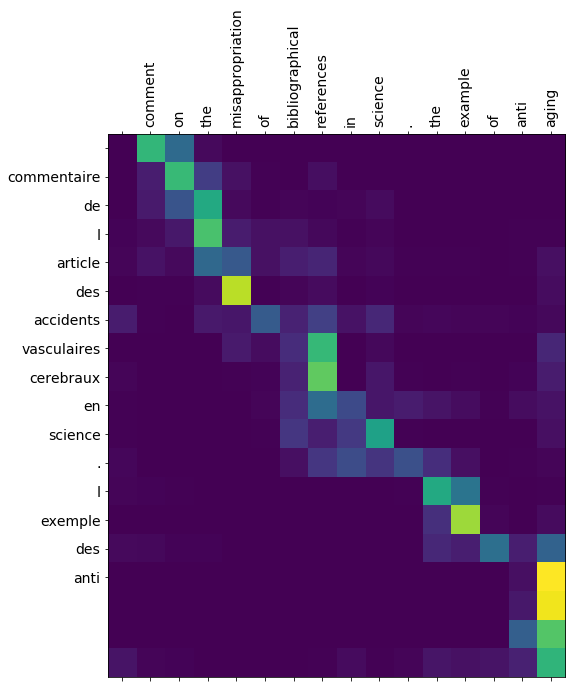

(' commentaire de l article des accidents vasculaires cerebraux en science . l exemple des anti parents ',
 0.5946035575013605,
 63.0)

In [0]:
src_sent = 'comment on the misappropriation of bibliographical references in science . the example of anti aging medicine'
tgt_sent = 'du detournement des references bibliographiques en science . l exemple de la medecine anti age '


translate_en_fr(src_sent,
                tgt_sent, 
                verbose = True,
                plot_att = True)

In [0]:
test_set_pred(src_test, tgt_test, verbose = True)

target sentence id: [171, 262, 4, 61, 6, 4303]
INFO:tensorflow:Restoring parameters from ckpt-exp09/google-brain-uni-rmsprop-7800
target sentence id: [  1 112   8 303   6 112   4   5  53  12  53   4   5  53   2]
Source Sentence:  current state of medicine in spain 
Real Translation:  etat actuel de la medecine en espagne 
Predicted Translation:  etat des lieux et etat de la medecine en medecine de la medecine 
Levenshetein Distance: 34.0
***BLEU Score***: 0
                                                                                         
target sentence id: [204, 11, 5, 29, 4, 1201, 4, 5, 2573]
INFO:tensorflow:Restoring parameters from ckpt-exp09/google-brain-uni-rmsprop-7800
target sentence id: [   1  887   10    7   32    8 2004    4    7  309    4    7   34    2]
Source Sentence:  contribution to the study of accidents of the teeth 
Real Translation:  contribution a l etude des accidents de la dentition 
Predicted Translation:  contribution a l etude des crises de l asthme d

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


INFO:tensorflow:Restoring parameters from ckpt-exp09/google-brain-uni-rmsprop-7800
target sentence id: [   1   47    8   77 1301    2]
Source Sentence:  surgery of periodontal diseases 
Real Translation:  la chirurgie des parodontolyses 
Predicted Translation:  chirurgie des maladies metaboliques 
Levenshetein Distance: 17.0
***BLEU Score***: 0
                                                                                         
target sentence id: [3718, 3, 3, 4, 3]
INFO:tensorflow:Restoring parameters from ckpt-exp09/google-brain-uni-rmsprop-7800
target sentence id: [   1    5  665 1775    4  392    9  237   19    5 2061  105  414   89
  738  665  272  518    4  537    4   68  468   16   90  105    4   39
    4   99  802    4    5  248  115    4    5  161   20    2]
Source Sentence:  die peripheren durchblutungsstorungen of paradentiums 
Real Translation:  die peripheren durchblutungsstorungen des paradentiums 
Predicted Translation:  la tres autorite de neuf d origine . la tomod

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


INFO:tensorflow:Restoring parameters from ckpt-exp09/google-brain-uni-rmsprop-7800
target sentence id: [   1 1528 2607    4    5 2271   72    2]
Source Sentence:  endocrine glands of cephalopods 
Real Translation:  les glandes endocrines des cephalopodes 
Predicted Translation:  adenome visuelle de la glande adulte 
Levenshetein Distance: 33.0
***BLEU Score***: 0
                                                                                         
target sentence id: [5, 2044, 3449, 7, 123]
INFO:tensorflow:Restoring parameters from ckpt-exp09/google-brain-uni-rmsprop-7800
target sentence id: [   1   15  781 3548    6    4    5  148    2]
Source Sentence:  the mediterranean climate and tuberculosis 
Real Translation:  le climat mediterraneen et les tuberculoses 
Predicted Translation:  le mal antoine et de la tuberculose 
Levenshetein Distance: 19.0
***BLEU Score***: 0
                                                                                         
target sentence id: [209,

target sentence id: [2938, 6375, 6, 8, 195, 83]
INFO:tensorflow:Restoring parameters from ckpt-exp09/google-brain-uni-rmsprop-7800
target sentence id: [  1   7 198   4   7  34  22  16  34 321   2]
Source Sentence: myositis ossificans in a young child 
Real Translation: myosite ossifiante chez un jeune enfant
Predicted Translation:  l atteinte de l enfant chez un enfant jeune 
Levenshetein Distance: 28.0
***BLEU Score***: 0


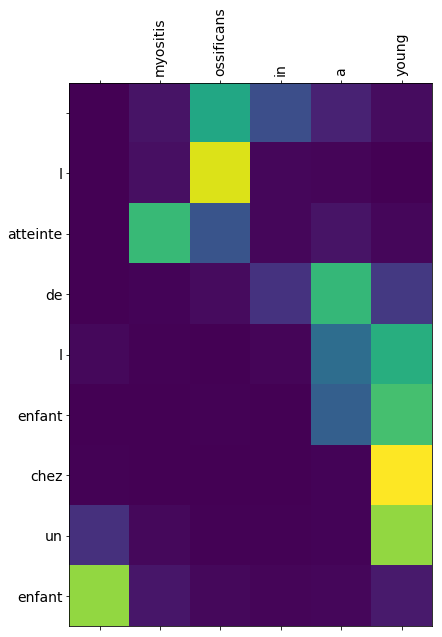

(' l atteinte de l enfant chez un enfant jeune ', 0, 28.0)

In [0]:
src_sent = 'myositis ossificans in a young child '
tgt_sent = 'myosite ossifiante chez un jeune enfant'


translate_en_fr(src_sent,
                tgt_sent, 
                verbose = True,
                plot_att = True)